# Extended n-Point Problem (XnP)

## Summary

This code (to a large degree) solves the n-point problem for a combination of perspective measurement and depth measurement and also support fusion over several camera at different pose (binocular). 

It is intended for the situation with enough points, such that the problem has a unique optimal solution not for the case (e.g. for 3 points) where ambiguities arise. However, it can handle situation also with a single monocular camera. The XnP algorithm roughly follows the following outline:
   - condense problem into a 13*13 matrix $M^TM$ such that $\bar T^T (M^TM) \bar T$ is a 12-D quadratic optimization
     problem for the sought transform $\bar T$ as a flattened vector. One column/row is used to 
     represent all 2nd, 1st and 0 order coefficients all in one matrix.
   - separate rotation problem via Schur-Complement as $\bar R^T \tilde P \bar R$, with 10*10 $\tilde P$
   - try a precomputed set of equally spaced rotations and choose the one with smalles value as initial guess
   - obtain translation via Schur-Complement solution
   - refine the solution iteratively as a 6D least square problem on the SE(3) manifold

Alternatively if an initial guess is available the code also supports

   - condense problem into a 13*13 matrix $M^TM$ as above
   - refine the initial guess (iteratively) as 6D least square problem on the SE(3) manifold
   - obtain 6*6 covariance of the refined solution and according log-likelihood function

## Preliminaries
The following perspective equation is assumed
$$
   p^C = T_{CR}T_{RO}p^O, \quad p^I = p_0 + f\frac{p^C_{12}}{p^C_3}, \quad T_{RO} = T
$$
where $p^I$ are the points image coordinates, $p_0$ is the image center, $f$ the focal length, $T_{RO}$, short $T$ is the
sought transformation Object in Reference which maps a point from object to reference coordinates and $p^O$ the point in object coordinates. $T_{CR}$ is the known transformation reference in camera, which maps a point from 
reference coordinates to the coordinate system of that camera. $()_1, ()_2, ()_3$ refer to the respective row of the matrix. All indices in the mathematical description start with 1 but with 0 in the Python code.

This python notebook contains the code, auxiliary code for testing, unit tests and a running through example.

In [1]:
# General functions
import numpy as np
import math
from math import pi, cos, sin, sqrt
import random as random
from numpy.linalg import inv
from scipy import linalg
import pytest
import matplotlib.pyplot as plt
import operator
from statistics import mean

# Parameter for the used Huber distribution. Above a residual norm of huberDelta the Huber-loss becomes
# linear, below it is quadratic. According to the Chi^2 distribution 85% of all regular measurements 
# should be in that range.
huberDelta = 2

# Camera intrinsics defined as a dict with entries
# f : focal length, imgW: image width, imgH: image height, u0, u-coordiante center, v0: v-coordinate center
# refInCam transformation taking a point expressed in reference-coordinates to camera-coordinates

def persp (cam, pO, OInRef):
    '''Perspective camera model: Returns the image coordinates of point pO (given in object coordinates) 
     for a given object pose relative to the reference frame. The pose of the camera relative to the reference
     frame is taken from cam. If the point is behind the camera, None is returned. The camera frame has origin in the optical
     center, X points right, Y down and Z into the viewing direction from the camera.'''
    assert (cam["type"]=="perspective")
    pC = cam["refInCam"].dot(OInRef.dot(pO))
    if pC[2]<=0: return None
    return np.array([cam["u0"]+cam["f"]*pC[0]/pC[2], cam["v0"]+cam["f"]*pC[1]/pC[2]])

def depth (cam, pO, OInRef):
    '''depth camera model returns the depth that should be measured of a point pO (given in object coordinates) 
     for a given object pose relative to the reference frame. The pose of the camera relative to the reference
     frame is taken from cam. '''
    assert (cam["type"]=="depth")
    pC = cam["refInCam"].dot(OInRef.dot(pO))
    return pC[2]

def point (cam, pO, OInRef):
    '''The point camera model returns a 3D point in camera coordinates.'''
    assert (cam["type"]=="depth")
    pC = cam["refInCam"].dot(OInRef.dot(pO))
    return pC

def nOfDatum (cam):
    '''Returns how many DOF each measurement of this camera has.'''
    tp = cam["type"]
    if tp=="perspective" or tp==None:
        return 2
    elif tp=="depth":
        return 1
    elif tp=="points":
        return 3
    else:
        raise ValueError (f"cam['type']=={tp} unknown")

def diffRot (v):
    '''Returns the skew-symmetric differential rotation matrix around v.'''
    return np.array([[    0,-v[2], v[1]],
                     [ v[2],    0,-v[0]],
                     [-v[1], v[0],    0]])

def rot (v):
    '''Rodrigues formula. Computes a rotation around v by angle |v|.'''
    return linalg.expm(diffRot(v))

def arot(R):
    '''Returns the rotation axis of R scaled by the angle of rotation.'''
    V = linalg.logm(R)
    return np.array([(V[2,1]-V[1,2])/2, (V[2,0]-V[0,2])/2, (V[1,0]-V[0,1])/2])

def randomRot (angle):
    '''Computes a random rotation matrix with an average angle of angle'''
    sigma = angle / math.sqrt(3)
    v = np.array([random.gauss(0,sigma), random.gauss(0,sigma), random.gauss(0,sigma)])
    return rot(v)

def diffT (v):
    '''Returns the differential transform parametrized by v in R^6.'''
    return np.array([[    0,-v[2], v[1], v[3]],
                     [ v[2],    0,-v[0], v[4]],
                     [-v[1], v[0],    0, v[5]],
                     [    0,    0,    0,    0]])

def transf (v):
    '''Returns the non-differential transform parametrized by v in R^6.'''
    return linalg.expm(diffT(v))

def boxplus (T, v):
    '''[+]-operator used for least-square estimating a transform'''
    return T.dot(transf(v))

def RtToT (R, t):
    '''Combines a rotation and a translation to a transform'''
    return np.array([[R[0,0], R[0,1], R[0,2], t[0]],
                     [R[1,0], R[1,1], R[1,2], t[1]],
                     [R[2,0], R[2,1], R[2,2], t[2]],
                     [     0,      0,      0,  1]])

def randomT (angle, d):
    R = randomRot (angle)
    t = np.array([random.uniform(-d,d), random.uniform(-d,d), random.uniform(-d,d)]);
    return RtToT (R, t)

def TToV (T):
    '''Returns a v such that diffT(v)=T (for T's where this is possible). This can also
       be used as an approximate inverse of transf for small v.'''
    return np.array([(T[2,1]-T[1,2])/2, (T[0,2]-T[2,0])/2, (T[1,0]-T[0,1])/2, T[0,3], T[1,3], T[2,3]])

def boxminus (T2, T1):
    '''[-] operator returning a 6D vector delta, such that T1[+]delta = T2.'''
    return TToV (linalg.logm(inv(T1).dot(T2)))

def frobErr (A, B):
    '''Frobenius norm error between two matrices'''
    return np.linalg.norm(A-B, ord='fro')

def ADD (T1, T2, pList):
    '''Returns the average distance of the points pList[:,i] transformed by T1 vs. T2.
       This is the usual metric for object pose estimation, where pList contains the
       object model points.'''
    return np.mean(np.linalg.norm((T1-T2).dot(pList),axis=0))

def ADDStar (T1, T2, pList):
    '''Conceptually similar to ADD but returns the root of average squared distances
       of the points pList[:,i] transformed by T1 vs. T2. This measure has nicer
       analytical properties than ADD, in particular an expected ADDStar error can
       be computed from a [+] covariance matrix.'''
    return math.sqrt(np.mean(np.linalg.norm((T1-T2).dot(pList),axis=0)**2))

def TToR (T):
    '''Returns the rotation part T[0:3,0:3] of T.'''
    return T[0:3,0:3]

def randomP (d):
    '''Returns a vector in the +/-d range with homogenous 1 as 4th component'''
    return np.array([random.uniform(-d,d), random.uniform(-d,d), random.uniform(-d,d),1]);

def unitTestTToV():
    '''Checks that TToV (T) and diffT(v) are inverse and this holds for small v and transf.'''
    v1 = np.random.rand (6)
    v2 = TToV(diffT(v1))
    np.testing.assert_almost_equal (v1, v2)
    v3 = v1 / 1E4
    v4 = TToV(transf(v3))
    np.testing.assert_almost_equal (v3, v4)
    
def unitTestBoxOperators():
    v1 = np.random.rand (6)
    T1 = randomT (0.001, 1)
    v2 = boxminus(boxplus(T1, v1), T1)
    np.testing.assert_almost_equal (v1, v2)
    
def unitTestADD():
    '''Runs ADD for a cube and pure translation / rotation along a cardinal axis.'''
    cube = np.array([[1,-1, 1,-1, 1,-1, 1,-1],
                     [1, 1,-1,-1, 1, 1,-1,-1],
                     [1, 1, 1, 1,-1,-1,-1,-1],
                     [1, 1, 1, 1, 1, 1, 1,1]])
    t = random.gauss(0,1)
    r = random.gauss(0,1)
    c = cos(r)
    s = sin(r)
    T1 = np.identity(4)
    T2 = np.array([[1,0, 0,t],
                   [0,c,-s,0],
                   [0,s, c,0],
                   [0,0, 0, 1]])
    add1 = ADD(T1, T2, cube)
    np.testing.assert_almost_equal (add1, math.hypot(t, sqrt(2)*2*sin(r/2)))

In [2]:
# Unit tests
unitTestTToV()
unitTestBoxOperators()
unitTestADD()

## Code to build a random XnP-problem

In [3]:
# ************ Code to construct a pnp Problem *****************
def randomWeightMatrix (sigmaLow, sigmaHigh):
    '''Returns a random 2D weighting matrix W, that corresponds
       to a random std. deviation between sigmaLow and sigmaHigh
       in two random orthogonal directions as well as a drawn
       random sample vector corresponding to this distribution v.
       Thus W.dot(v) is 2-D-Std. Gaussian.'''
    sg0 = random.uniform(sigmaLow, sigmaHigh)
    sg1 = random.uniform(sigmaLow, sigmaHigh)
    angle = random.uniform(0,2*pi)
    c  = cos(angle)
    s  = sin(angle)
    v0 = random.gauss (0,sg0)
    v1 = random.gauss (0,sg1)
    return (np.array([[c/sg0, s/sg0],
                      [-s/sg1, c/sg1]]),
            np.array([v0*c-v1*s, v0*s+v1*c]))

def unitTestRandomWeightMatrix (sigmaLow, sigmaHigh):
    '''Checks that W.dot(v) is distributed as 2-D-Std.-Gaussian by checking the mean
       of the squared norm that should be chi^2 distributed.'''
    sum = 0
    n = 100000
    for ctr in range(0, n):
        W,v = randomWeightMatrix (sigmaLow, sigmaHigh)
        Wv = W.dot(v)
        sum += Wv.dot(Wv)
    assert abs(sum-2*n)<5*sqrt(4*n) # assert diff to mean is below 5*std. dev.
    
def gaussPlusOutlier (mu, sigma, outlier=0.1):
    '''Samples from a Gaussian+Outlier distribution, in particular
       (1-outlier)*N(mu,sigma) + outlier*N(mu,sigma/outlier)'''
    if random.uniform(0,1)<outlier:
        return random.gauss(mu,sigma/outlier)
    else:
        return random.gauss(mu,sigma)

def makeDataEntry (cam, OInR, objSize, sigmaLow, sigmaHigh, noise):
    '''Generates a simulated perspective test datum. See makeData.'''
    assert (objSize<0.6)
    d    = objSize*OInR[2,3]
    pInO = np.array([random.uniform(-d/2,+d/2), random.uniform(-d/2,+d/2), random.uniform(-d/2,+d/2), 1]);

    pInImg = persp(cam, pInO, OInR)
    if pInImg is None: return None
    W, eps = randomWeightMatrix (sigmaLow, sigmaHigh)
    if noise=="gauss": 
        pInImg = pInImg+eps
    elif noise=="gauss+outlier":
        pInImg = pInImg+eps
        if random.uniform(0,1)<0.1: pInImg = pInImg+10*eps
    elif noise=="" or noise==None: pInImg = pInImg
    else:
        raise ValueError("unknown noise model"+noise)
    return (pInO[0], pInO[1], pInO[2], W[0,0], W[0,1], W[1,0], W[1,1], pInImg[0], pInImg[1])

def makeData (n, cam, OInR, objSize, sigmaLow, sigmaHigh, noise):
    '''Generates n simulated test data.        
       OinR is the groundtruth object in reference pose. 
       The object is considered a cube aligned with the object coordinate system
       of length objSize*OInC[2,3], i.e. objSize is given as a percentage of the
       distance to the camera. 

       It also draws a random weighting matrix
       having uncertainty between sigmaLow and sigmaHigh in every direction and optionally perturbs the
       true image position by such noise. noise can be None or "none", "gauss", "gauss+outlier.
       It return a flattened tuples, with point in object coordinates,
       2*2 weighting matrix, and perturbed point in image coordinates.'''
    assert (cam["type"]=="perspective")
    dat = [makeDataEntry(cam, OInR, objSize, sigmaLow, sigmaHigh, noise) for i in range(n)]
    return [d for d in dat if not d is None]

def makeDepthDataEntry (cam, OInR, objSize, sigmaLow, sigmaHigh, noise):
    '''Generates a simulated perspective test datum. See makeDepthData.'''
    assert (objSize<0.6)
    d     = objSize*OInR[2,3]
    pInO  = np.array([random.uniform(-d/2,+d/2), random.uniform(-d/2,+d/2), random.uniform(-d/2,+d/2), 1]);
    z     = depth (cam, pInO, OInR)
    sigma = random.uniform(sigmaLow, sigmaHigh)
    w     = 1/sigma
    
    if noise == "gauss": 
        z = z+random.gauss(0,sigma)
    if noise == "gauss+outlier":
        z = z+random.gauss(0,sigma)
        if random.uniform(0,1)<0.1: z = z+random.gauss(10*sigma)
    return (pInO[0], pInO[1], pInO[2], w, z)
    
def makeDepthData (n, cam, OInR, objSize, sigmaLow, sigmaHigh, noise):
    '''Generates n simulated test data. From cam actually only the pose is needed.       
       OinR is the groundtruth object in reference pose. 
       The object is considered a cube aligned with the object coordinate system
       of length objSize*OInC[2,3], i.e. objSize is given as a percentage of the
       distance to the camera. noise can be None or "none", "gauss", "gauss+outlier".
       
       It returns flattened tuples with a point in object coordinate, a weight
       and the perturbed z-coordinate.'''
    assert (cam["type"]=="depth")
    dat = [makeDepthDataEntry(cam, OInR, objSize, sigmaLow, sigmaHigh, noise) for i in range(n)]
    return [d for d in dat if not d is None]

def randomOInR(cam, maxRange):
    '''Computes a random object-in-reference transform, such that the origin is in the view frustrum
       from the origin.'''
    # Object center in camera
    z = random.uniform (0.3*maxRange, maxRange)
    x = z/cam["f"]*random.uniform(-cam["u0"], cam["imgW"]-cam["u0"])
    y = z/cam["f"]*random.uniform(-cam["v0"], cam["imgH"]-cam["v0"])
    t = np.array([x,y,z])
    # Randomly rotate object
    R = randomRot (math.pi)
    # Transform to matrix and to reference systems
    return cam["refInCam"].dot(RtToT (R,t))

def randomCam (type="perspective"):
    '''Computes a random camera calibration with reasonable values for unit tests'''
    imgW = random.uniform(800,1200)
    imgH = random.uniform(800,1200)
    cam = {"type":type,
           "f":imgW*random.uniform(0.4,0.6),
           "imgW":imgW, "imgH":imgH,
           "u0":imgW/2+random.uniform(-100,100), "v0":imgH/2+random.uniform(-100,100),
          "refInCam":randomT(0.05, 0.3)} # We only allow a slight rotation so still Z-axis is roughly viewing direction
    return cam

In [4]:
# Unit tests
unitTestRandomWeightMatrix(1,10)

In [5]:
# Running through example
class Bunch:
    def __init__(self, **kwds):
        self.__dict__.update(kwds)
        
ex = Bunch(nrOfPoints=20)
ex.cam = {"type":"perspective", 
          "f":800, "imgW":1024, "imgH":768, "u0":1024/2, "v0":768/2, 
          "refInCam":np.array([[1, 0, 0, 0],
                               [0, 1, 0, 0],
                               [0, 0, 1, 0],
                               [0, 0, 0, 1]])
      }

ex.OInR = np.array(
             [[0, 1, 0, 2],
              [1, 0, 0, -2],
              [0, 0,-1, 10],
              [0, 0, 0,  1]])

ex.data = makeData(ex.nrOfPoints, ex.cam, ex.OInR, 0.2, 1, 5, "gauss")

## Compiling the perspective input data as a 12-dimensional quadratic optimization problem
The code is based on the following flattening of the SE(3) matrix $T$ which transforms a point from object to camera coordinates into a vector $\bar T$ .
$$T=\begin{pmatrix}a&b&c&j\\d&e&f&k\\g&h&i&l\\0&0&0&1\end{pmatrix}, 
\quad \bar T = \left(a, b, c, d, e, f, g, h, i, 1, j, k, l \right)^T$$
This means the first 9 entries define the orientation row-wise while the last 3 entries define the position.
In between there is a 1 (one) entry. This entry allows to combine 0th and 1st order coefficients for $\mathbb{R}^n
\rightarrow\mathbb{R}^m$
mappings, as well as 0th, 1st and 2nd order coefficients for $\mathbb{R}^\mathbb{n}\rightarrow\mathbb{R}$ mappings into a single matrix. This is similar to homogenous coordinate transforms.

The first step of projecting an object point to the image is transforming it into 3-D camera coordinates. This
transformation $p^C = T_{CR} T p^O$ consists of a known transformation $T_{CR}$ and a known point $p^O$ and an
unknown transformation $T=T_{RO}$. Hence it is linear in $T$ and can be written as a matrix times $\bar T$
$$
   p^C = T_{CR} T p^O = \\
   \underbrace{
   \begin{pmatrix}
       {\color{red}a} & {\color{red}b} & {\color{red}c} &
       {\color{red}d} & {\color{red}e} & {\color{red}f} &
       {\color{red}g} & {\color{red}h} & {\color{red}i} &
       {\color{red}1} &
       {\color{red}j} & {\color{red}k} & {\color{red}l} \\
       %
       % a                   b                     c
       p_1 T_{CR\bullet 1} & p_2 T_{CR\bullet 1} & p_3 T_{CR\bullet 1} &
       % d                   e                     f
       p_1 T_{CR\bullet 2} & p_2 T_{CR\bullet 2} & p_3 T_{CR\bullet 2} &
       % g                   h                     i
       p_1 T_{CR\bullet 3} & p_2 T_{CR\bullet 3} & p_3 T_{CR\bullet 3} &
       % 1
       T_{CR\bullet 4} &
       % j                   k                     l
       T_{CR\bullet 1}     & T_{CR\bullet 2}     & T_{CR\bullet 3} 
   \end{pmatrix}}_{A} \bar T \\
   = A \bar T
$$
Here $T_{CR\bullet j}$ is the $j$-th row of $T_{CR}$ and the red letters are just labels indicating with which entry
of $T$ this entry of the matrix is multiplied. Note, that the fourth column of $T_{CR}$ is multiplied with the
constant $1$ entry of $\bar T$ making the equation affine not linear in the case that $T_{CR}$ contains translation.
If this happens as in the binocular case, the resulting equations are not scale invariant any more which is a
structural extension to the monocular PnP problem.

The measurement equation for one point is obtained by multiplying the perspective equation above with $p^C_3$, i.e.
the point's camera-z coordinate and with a weight matrix $W$

$$
0
= W\left(d p^C_3 - f p^C_{1..2}\right) 
= W \underbrace{
    \begin{pmatrix}
     -f & 0 & d_1 & 0\\
     0 & -f & d_2 & 0
     \end{pmatrix}}_{B} p^C
= WBp^C
\quad p = p^O, \quad d = p^I-p_0
$$

Multiplying all three matrices $WBA$, we get 
$$
 0 = \underbrace{WBA}_M \bar T = M \bar T
$$

Now we call this $2\times 13$ matrix for the i-th measurement $M_i$ and stack for all measurements $i$. This
results in a matrix $M$, where $0=M \bar T$. With noise we want to minize

$$
   |M \bar T|_2^2 = \bar T^T (M^TM) \bar T
$$

$M^TM$, which describes the 12D-minimization problem has fixed dimension $13\times 13$ regardless of the number of points.

## Uncertainty normalization factor
The rational perspective equation has been multiplied by $p^C_3$ to get rid of the quotient and make the equation linear. This also weights the residual in that equation by $p^C_3$ and effectively divides the std. deviation assumed
for this measurement by $p^C_3$, which is unknown a-priori. Once the different measurements, i.e. rows of $M$ are 
accumulated as $M^TM$, these per-measurement factors cannot be corrected anymore but only a common factor 
for all measurements.

We now consider, how to compute this factor after an estimate for $T$ has been obtained, but in a way that does
not require to go through all pixels again. Instead similar to $M^TM$, coefficient will be accumulated that will
allow to compute the factor later when $T$ is available. The factor $f$ we want to obtain is the average $p^C_3$
weighted by $|W|_F$.
$$
    f  = \bigl(\sum_i |W^i|_F\bigr)^{-1} \sum_i |W^i|_F p^{Ci}_3
       = \bigl(\sum_i |W^i|_F\bigr)^{-1} 
         \bigl(\sum_i |W^i|_F A^i_3\bigr) \bar T 
$$
The number and vector above can be combined into a single 14D vector $l$ using homogenous notation:
$$
    l = \sum_i |W^i|_F (A^i_3 1) \quad f = \frac{l_{1\ldots13}\bar T}{l_{14}}
$$
Please note that this factor is only needed to get statistically correct rms and pose covariance output.
If the pose covariance is scaled using the rms this feature and the $l$-vector is not needed.

In [6]:

# ************* Code to compute MTM and the conversion functions needed to evaluate it
def TToTBar (T):
    '''Converts a SE(3) matrix T into a stacked vector \bar T according to the above stacking convention'''
    return np.array([T[0,0], T[0,1], T[0,2], T[1,0], T[1,1], T[1,2], T[2,0], T[2,1], T[2,2], 1, T[0,3], T[1,3], T[2,3]])
    
def TBarToT (TBar):
    '''Converts a stacked vector \bar T into a 4*4 matrix according to the above stacking convention'''
    return np.array([[TBar[0], TBar[1], TBar[2], TBar[10]],
                     [TBar[3], TBar[4], TBar[5], TBar[11]],
                     [TBar[6], TBar[7], TBar[8], TBar[12]],
                     [      0,       0,       0, TBar[9]]])

def RToRBar (R):
    '''Converts a SO(3) matrix R into a stacked vector \bar R according to the above stacking convention'''
    return np.array([R[0,0], R[0,1], R[0,2], R[1,0], R[1,1], R[1,2], R[2,0], R[2,1], R[2,2], 1])
    
def RBarToR (RBar):
    '''Converts a stacked vector \bar R into a 3*3 matrix according to the above stacking convention'''
    return np.array([[RBar[0], RBar[1], RBar[2]],
                     [RBar[3], RBar[4], RBar[5]],
                     [RBar[6], RBar[7], RBar[8]]])

def RBartToT (RBar, t):
    '''Converts a stacked vector \bar R and a vector \bar t into a 4*4 matrix according to the above stacking convention'''
    return np.array([[RBar[0], RBar[1], RBar[2], t[0]],
                     [RBar[3], RBar[4], RBar[5], t[1]],
                     [RBar[6], RBar[7], RBar[8], t[2]],
                     [     0,      0,      0,    RBar[9]]])
    
def matrixA (cam, pO):
    '''Implementation of the matrix A from the above equation'''
    p1, p2, p3, _ = pO
    TCR = cam["refInCam"]
    TCR1 = TCR[:,0]
    TCR2 = TCR[:,1]
    TCR3 = TCR[:,2]
    TCR4 = TCR[:,3]
    return np.stack((p1*TCR1, p2*TCR1, p3*TCR1, 
                      p1*TCR2, p2*TCR2, p3*TCR2, 
                      p1*TCR3, p2*TCR3, p3*TCR3, 
                      TCR4,
                      TCR1, TCR2, TCR3), axis=1)

def unitTestMatrixA():
    '''Makes a unit test by asserting T_CR T p^O = A \bar T'''
    cam = randomCam()
    pO = randomP(1)
    T  = randomT(pi/2, 1) 
    A = matrixA (cam, pO)
    pC = cam["refInCam"].dot(T).dot(pO)
    pC2 = A.dot(TToTBar(T))
    np.testing.assert_almost_equal (pC, pC2)
    
def matrixB (cam, pI):
    d1 = pI[0]-cam["u0"]
    d2 = pI[1]-cam["v0"]
    f = cam["f"]
    return np.array([[-f,  0, d1, 0],
                     [ 0, -f, d2, 0]])

def unpackDataEntry (dataEntry):
    '''Returns pO (4-vector), W (2*2 matrix) and pI (2-vector) from one flattened data entry'''
    pO  = np.array([dataEntry[0], dataEntry[1], dataEntry[2], 1])
    W   = np.array([[dataEntry[3], dataEntry[4]],
                    [dataEntry[5], dataEntry[6]]])
    pI  = np.array([dataEntry[7], dataEntry[8]])
    return (pO, W, pI)

def errorLoss (res, useHuber=False):
    '''Returns either quadratic or Huber loss of the residual norm res.'''
    assert res>=0
    if useHuber and res>huberDelta:
        return huberDelta**2 + 2*huberDelta*(res-huberDelta)
    else:
        return res**2;
    
def reweightingFactor (res, useHuber=False):
    '''Returns the factor by which the residual (before squaring) is divided in iteratively reweighted
       least squares'''
    if useHuber and res>huberDelta:
        return sqrt(res**2/errorLoss(res, useHuber))
    else:
        return 1

def errorOfEntryForTPersp (cam, dataEntry, T, useHuber=False):
    '''Computes the squared error a single dataEntry has for a given transformation T. Can be used to validate
       results of the more complicated computations.'''
    pO, W, pI = unpackDataEntry (dataEntry)
    pI2 = persp (cam, pO, T)
    if pI2 is None: return cam["f"]/10 # heuristic to have a large but not extreme value
    res = np.linalg.norm(W.dot(pI-pI2))
    return errorLoss (res, useHuber)

def errorOfDataForTPersp (cam, data, T, useHuber=False):
    return sum([errorOfEntryForTPersp (cam, entry, T, useHuber) for entry in data if entry is not None])

def rmsOfVal (cam, data, val):
    '''Computes a normalized rms val (which should be 1 on average) from the chi2-error for a given data set.'''
    n = nOfDatum (cam)*len(data)
    return sqrt(val/n)

def expectedRms (cam, data):
    '''Returns the expected value, rms should have for the given camera an data'''
    n = nOfDatum (cam)*len(data)
    return sqrt((n-6)/n)

def MRowPersp (cam, dataEntry):
    '''Implements the whole above equation taking one entry of the dataset including object point,
    image point and weighting matrix. It returns a double row of M and one term of l'''
    assert cam["type"]=="perspective"
    pO, W, pI = unpackDataEntry (dataEntry)
    A = matrixA (cam, pO)
    B = matrixB (cam, pI)
    l = np.linalg.norm(W)*np.hstack((A[2], 1))
    return (W.dot(B).dot(A), l)

def MRowPerspWithGuess (cam, dataEntry, TBreveBar):
    '''Version of MRowPersp when an initial guess is available. Uses the guess to get the weighting right
       and to perform a reweighted least squares estimation with the 2D-Huber-loss. '''
    assert cam["type"]=="perspective"
    pO, W, pI = unpackDataEntry (dataEntry)
    A = matrixA (cam, pO)
    B = matrixB (cam, pI)
    MRow = W.dot(B).dot(A)
    z = A[2].dot(TBreveBar)
    res = np.linalg.norm(MRow.dot(TBreveBar))/z
    # In the following three weighting factors are applied
    # a) Cancel the implicit weighting by the points Z coordinate using TBreveBar
    # b) Introduce a weighting by the Z coordinate of the origin to be roughly compatible
    #    with matrices obtained without an initial guess
    # c) weight by 1/max(1,res/delta) as an iteratively reweighted 
    #    least-squares approach to a 2D-Huber-loss to handle outliers
    factor = TBreveBar[12]/(z*reweightingFactor(res, True))
    #print(res, z, factor)
    MRow *= factor
    l = np.linalg.norm(W)*np.array([0,0,0,0,0,0,0,0,0,TBreveBar[12],0,0,0,1]) # implicit scaling factor is TBreve[2,3]
    return (MRow, l)


def makeMPersp (cam, data, TBreve=None):
    '''Computes the Matrix M from the input data
       Here |M \bar T|_2^2 is the optimization problem to be solved. 
       Also computes a vector l that describes the implicit weighting factor in l.
       If an initial guess TBreve is given, it is used to avoid the implicit weighting
       and to handle outliers with a 2D-Huber-loss'''
    if TBreve is None:
        MRowResults = [MRowPersp (cam, entry) for entry in data if not entry is None] 
    else:
        TBreveBar = TToTBar (TBreve)
        MRowResults = [MRowPerspWithGuess (cam, entry, TBreveBar) for entry in data if not entry is None]
    return (np.vstack([mr[0] for mr in MRowResults]), sum([mr[1] for mr in MRowResults]))

def implicitWeightingFactor (l, T):
    '''Returns an estimate of the implicit weighting factor (not-squared) present in M when
       the true pose is T based on the accumulated l vector.'''
    return l[:-1].dot(TToTBar(T))/l[-1]

def makeMtMPersp (cam, data, TBreve=None):
    '''Computes the Information Matrix MtM from the input data.
       This matrix has size 13^2 regardless of the number of points n.
       Here \bar T MtM bar T is the optimization problem to be solved.
       If an initial guess TBreve is given, it is used to avoid the implicit weighting
       and to handle outliers with a 2D-Huber-loss'''
    M, l = makeMPersp (cam, data, TBreve)
    return M.T.dot(M), l

def errorOfT (M, T):
    '''Returns the error that T has as a solution regarding M, which is |M \bar T|^2_n. For the
    ground truth this should be 2n*sigma*(implict weighting factor)^2'''
    Mt = M.dot(TToTBar(T))
    return Mt.T.dot(Mt)

def errorOfTWithMtM (MtM, T):
    '''Returns the error that T has as a solution regarding M^TM, which is \bar T^T MtM \bar T.
       For the ground truth this should be 2n*sigma*(implict weighting factor)^2'''
    TBar = TToTBar (T)
    return TBar.T.dot(MtM).dot(TBar)

def unitTestM ():
    '''Runs a random depth problem without and checks that M \bar T = 0
       and with noise and checks that the M \bar T has the statistically
       correct norm.  '''
    cam = randomCam ()
    OInR = randomOInR (cam, 10)
    data = makeData(10, cam, OInR, 0.2, 1, 5, None)
    print()
    assert(len(data)>=7) # require at least 7 out of 10 points to be visible
    MtM, l = makeMtMPersp (cam, data)
    assert errorOfTWithMtM (MtM, OInR)<1E-5
    data = makeData(10, cam, OInR, 0.2, 1, 5, "gauss")
    print()
    assert(len(data)>=7) # require at least 7 out of 10 points to be visible
    MtM, l = makeMtMPersp (cam, data)
    weightingFactor = implicitWeightingFactor (l, OInR)
    err1 = errorOfTWithMtM (MtM, OInR) / (weightingFactor**2)
    err2 = errorOfDataForTPersp (cam, data, OInR)
    # We can only assert a rough tolerance here, because the weightingFactor is an approximation
    np.testing.assert_allclose (err1, err2, 0.1) 
    MtM, l = makeMtMPersp (cam, data, OInR) # with weighting and Huber
    weightingFactor = implicitWeightingFactor (l, OInR)
    err3 = errorOfTWithMtM (MtM, OInR) / (weightingFactor**2)
    print("err based on MtM: %f, on raw data: %f, with iteratively reweighted Huber: %f"%(err1, err2, err3))
    assert err3 <= 1.000001*err2 # Huber only reduces the error
    assert err2 <= 1.2*err3 #at most 20% reduction by downweighting outliers
    
def unitTestHuber1 ():
    '''Checks that the definition of errorLoss and reweightingFactor are compatible'''
    for i in range(1000):
        res = random.uniform(0,2*huberDelta)
        useHuber = random.randint(0,1)==0
        val1 = errorLoss (res, useHuber)
        val2 = (res/reweightingFactor(res, useHuber))**2
        np.testing.assert_array_almost_equal (val1, val2)
    
def errorOfOneTest (cam, data, T, doUseHuber):
    '''Evaluates the least-squares
       error function for the ground truth T of the result and returns the loss. If doUseHuber is
       true the iteratively reweighted least squares loss is reported, otherwise the 
       regular least-squares loss.'''
    if doUseHuber:
        MtM, l = makeMtMPersp (cam, data, T)        
    else:
        MtM, l = makeMtMPersp (cam, data)            
    weightingFactor = implicitWeightingFactor (l, T)
    return errorOfTWithMtM (MtM, T) / (weightingFactor**2)
    
def unitTestHuber2():
    '''Unit test for the M generation with Huber loss using iteratively reweighted least-squares. 
    Tests that when creating a dataset with outliers the ground-truth chi^2 error is MUCH lower
    for the Huber loss than for the least-squares loss.'''
    cam = randomCam ()
    OInR = randomOInR (cam, 10)
    dataGauss = makeData(100, cam, OInR, 0.2, 1, 5, "gauss");
    errGauss = errorOfOneTest (cam, dataGauss, OInR, False)
    errGaussH = errorOfOneTest (cam, dataGauss, OInR, True)
    print ("Gauss Huber %f Gauss LS %f"%(errGaussH, errGauss))
    assert (errGaussH <= errGauss)
    assert (errGauss <=1.4*errGaussH)
    
    dataOut = makeData(100, cam, OInR, 0.2, 1, 5, "gauss+outlier");
    errOut = errorOfOneTest (cam, dataOut, OInR, False)
    errOutH = errorOfOneTest (cam, dataOut, OInR, True)
    print ("Outlier Huber %f Outlier LS %f"%(errOutH, errOut))
    assert (errOutH<=2*(2.0/11)*errOut) # should on average be 2/11th, 2 is a safety factor for randomness
    
def computeHuberExpectedLoss(mu, sigma, outlier):
    '''Monte-Carlo computes E(Huber(X, mu)) if X is distributed according to gaussOutlier(mu, sigma, outlier)'''
    X = [gaussPlusOutlier(mu, sigma, outlier) for ctr in range(10000)]
    L = [errorLoss(abs(x-mu)/sigma, True) for x in X]
    return mean(L)

In [7]:
# Unit tests
unitTestHuber1()
unitTestHuber2()
unitTestMatrixA()
unitTestM()
expectedHuberLoss = computeHuberExpectedLoss(0,1,0.1) # independent of mu and sigma
print("Expected Huber-loss of out gauss+outlier distribution is %f"%(expectedHuberLoss))

Gauss Huber 169.312851 Gauss LS 170.996942
Outlier Huber 648.070899 Outlier LS 2234.150312


err based on MtM: 22.127018, on raw data: 20.709251, with iteratively reweighted Huber: 20.497450
Expected Huber-loss of out gauss+outlier distribution is 3.749376


In [8]:
# Running through example
ex.M, _ = makeMPersp (ex.cam, ex.data)
ex.MtM, ex.l = makeMtMPersp (ex.cam, ex.data)

ex.factor = implicitWeightingFactor (ex.l, ex.OInR)**2
print("weighting factor %f"%(ex.factor))
print("chi^2-error %.0f should roughly be %.0f+/-%.0f"
       %(errorOfT (ex.M, ex.OInR), ex.factor*2*len(ex.data), ex.factor*sqrt(2*len(ex.data))))

weighting factor 99.146463
chi^2-error 3434 should roughly be 3966+/-627


## Compiling the depth input data as a 12-dimensional quadratic optimization problem
Here we compile a set of depth measurements as a Matrix M respectively M^TM. This can be stacked with resp. added to other matrices of this type obtained from other sensors to fuse the measurements. The advantage of fusing the sensors
on the M-level instead of on the level of an estimated pose with uncertainty is that both sensors contribute to the global optimization whereas in the other solution each sensor has to produce a global estimate on its own.

$p^C$ is obtained as $A\bar T$ as in the perspective case. The depth measurement measures the Z-component of $p^C$
with a weighting factor $w$ (inverse std.-deviation). Additionally the equation is weighted by z, so it can be
added to the perspective measurements which are implicitly weighted by $p^C_3$ for mathematical reasons.

$$
0 
= wz (z-p^C_3) = \underbrace{\begin{pmatrix}0& 0& -wz& wz^2\end{pmatrix}}_{C} p^C 
= \underbrace{CA}_{M}\bar T
$$



In [9]:
def matrixC (w, z):
    '''Matrix B (see above)'''
    return np.array([0, 0, -w*z, w*z**2])

def unpackDataEntryDepth (dataEntry):
    '''Returns pO (4-vector), w (number) and z (number) from one flattened data entry'''
    pO = np.array([dataEntry[0], dataEntry[1], dataEntry[2], 1])
    w  = dataEntry[3]
    z  = dataEntry[4]
    return (pO, w, z)

def errorOfEntryForTDepth (cam, dataEntry, T, useHuber=False):
    '''Computes the squared error a single depth dataEntry has for a given transformation T. Can be used to validate
       results of the more complicated computations.'''
    pO, w, z = unpackDataEntryDepth (dataEntry)
    z2 = depth (cam, pO, T)
    res = abs(w*(z-z2))
    return errorLoss (res, useHuber)

def errorOfDataForTDepth (cam, data, T, useHuber=False):
    return sum([errorOfEntryForTDepth (cam, entry, T, useHuber) for entry in data if entry is not None])
    
def MRowDepth (cam, dataEntry):
    '''Implements the whole above equation taking one entry of the depth dataset'''
    assert cam["type"]=="depth"
    pO, w, z = unpackDataEntryDepth (dataEntry)
    A = matrixA (cam, pO)
    C = matrixC (w, z)
    l = w*np.hstack((A[2], 1))
    return (C.dot(A), l)

def makeMDepth (cam, data, TBreve=None):
    '''Computes the Matrix M from the input data
       Here |M \bar T|_2^2 is the optimization problem to be solved. 
       Also computes a vector l that describes the implicit weighting factor in l'''
    MRowResults = [MRowDepth (cam, entry) for entry in data if not entry is None]
    return (np.vstack([mr[0] for mr in MRowResults]), sum([mr[1] for mr in MRowResults]))


def makeMtMDepth (cam, data, TBreve=None):
    '''Computes the Information Matrix MtM from the input data.
       This matrix has size 13^2 regardless of the number of points n.
       Here \bar T MtM bar T is the optimization problem to be solved.'''
    M, l = makeMDepth (cam, data, TBreve)
    return (M.T.dot(M), l)

def unitTestDepthM ():
    '''Runs a random depth problem without and checks that M \bar T = 0
       and with noise and checks that the M \bar T has the statistically
       correct norm.'''
    cam = randomCam (type="depth")
    OInR = randomOInR (cam, 10)
    nrOfPoints = 20
    data = makeDepthData(nrOfPoints, cam, OInR, 0.2, 0.01, 0.05, None)
    assert(len(data)>=.7*nrOfPoints) # require at least 70% of points to be visible
    MtM, l = makeMtMDepth (cam, data)
    assert errorOfTWithMtM (MtM, OInR)<1E-5
    data = makeDepthData(nrOfPoints, cam, OInR, 0.2, 0.01, 0.05, "gauss")
    assert(len(data)>=.7*nrOfPoints) # require at least 70% of points to be visible
    MtM, l = makeMtMDepth (cam, data)
    weightingFactor = implicitWeightingFactor (l, OInR)
    err1 = errorOfTWithMtM (MtM, OInR) / (weightingFactor**2)
    err2 = errorOfDataForTDepth (cam, data, OInR)
    # We can only assert a rough tolerance here, because the weightingFactor is an approximation
    np.testing.assert_allclose (err1, err2, 0.12) 

In [10]:
unitTestDepthM()

## Compiling the point input data as a 12-dimensional quadratic optimization problem
Here we compile a set of point measurements as a Matrix M respectively M^TM. This can be stacked with resp. added to other matrices of this type obtained from other sensors to fuse the measurements. The advantage of fusing the sensors
on the M-level instead of on the level of an estimated pose with uncertainty is that both sensors contribute to the global optimization whereas in the other solution each sensor has to produce a global estimate on its own.

$p^C$ is obtained as $A\bar T$ as in the perspective case. The point measurement $p^m$ measures simply $p^C$
with a weighting factor $w$ (inverse std.-deviation). Additionally the equation is weighted by $p^m_3=z$, so it can be
added to the perspective measurements which are implicitly weighted by $p^C_3$ for mathematical reasons.

$$
0 
= wz (p^m-p^C) = \underbrace{
\begin{pmatrix}
    -wz&  0&  0& p^m_1wz\\
     0& -wz&  0& p^m_2wz\\
     0&  0& -wz& p^m_3wz
\end{pmatrix}}_{D} \; p^C 
= \underbrace{DA}_{M}\bar T
$$

In [11]:
def matrixD (w, pm):
    '''Matrix D (see above)'''
    z = pm[2]
    return np.array([[-w*z,   0,   0, w*z*pm[0]],
                     [   0,-w*z,   0, w*z*pm[1]],
                     [   0,   0,-w*z, w*z*pm[2]]])

def unpackDataEntryPoint (dataEntry):
    '''Returns pO (4-vector), w (number) and pm (4-vector) from one flattened data entry'''
    pO = np.array([dataEntry[0], dataEntry[1], dataEntry[2], 1])
    z  = dataEntry[3]
    pm = np.array([dataEntry[4], dataEntry[5], dataEntry[6], 1])
    return pO, z, pm

def MRowPoint (cam, dataEntry):
    '''Implements the whole above equation taking one entry of the depth dataset'''
    assert cam["type"]=="point"
    pO, w, pm = unpackDataEntryPoint (dataEntry)
    A = matrixA (cam, pO)
    D = matrixD (w, pm)
    l = w*np.hstack((A[2], 1))
    return (D.dot(A), l)

def makeMPoint (cam, data, TBreve=None):
    '''Computes the Matrix M from the input data
       Here |M \bar T|_2^2 is the optimization problem to be solved. 
       Also computes a vector l that describes the implicit weighting factor in l'''
    MRowResults = [MRowPoint (cam, entry) for entry in data if not entry is None]
    return (np.vstack([mr[0] for mr in MRowResults]), sum([mr[1] for mr in MRowResults]))

def makeMtMPoint (cam, data, TBreve=None):
    '''Computes the Information Matrix MtM from the input data.
       This matrix has size 13^2 regardless of the number of points n.
       Here \bar T MtM bar T is the optimization problem to be solved.'''
    M, l = makeMPoint (cam, data, TBreve)
    return (M.T.dot(M), l)

## Heterogenous Multi-Sensor generalization
Above we have derived different functions for perspective, depth and point data. This section combines all allowing to have data from several sensors of different type.

In [12]:
def makeMtM (cam, data, TBreve=None):
    '''Switches between makeMtMPersp and makeMtMDepth according to cam["type"]'''
    tp = cam["type"]
    if tp=="perspective" or tp==None:
        return makeMtMPersp (cam, data, TBreve)
    elif tp=="depth":
        return makeMtMDepth (cam, data, TBreve)
    elif tp=="point":
        return makeMtMPoint (cam, data, TBreve)
    else:
        raise ValueError (f"cam['type']=={tp} unknown")

def makeMtMCamWithData (camWithData, TBreve):
    '''Computes MtM for a list of cameras bith associated data (formally list of pairs (cam, data))'''
    MtMLCams = [makeMtM(c, d, TBreve) for (c,d) in camWithData]
    return sum([entry[0] for entry in MtMLCams]), sum([entry[1] for entry in MtMLCams])

def errorOfDataForT (cam, data, T, useHuber=False):
    '''Returns the error (ls or Huber) that data has if T is the object in ref transform. Switches models
       according to cam.type'''
    tp = cam["type"]
    if tp=="perspective" or tp==None:
        return errorOfDataForTPersp (cam, data, T, useHuber)
    elif tp=="depth":
        return errorOfDataForTDepth (cam, data, T, useHuber)
    elif tp=="point":
        return errorOfDataForTPoint (cam, data, T, useHuber)
    else:
        raise ValueError (f"cam['type']=={tp} unknown")

def errorOfCamWithDataForT (camsWithData, T, useHuber=False):
    return sum([errorOfDataForT (cam, data, T, useHuber) for (cam, data) in camsWithData])

def rmsOfValForCamWithData (camsWithData, val):
    '''Computes a normalized rms val (which should be 1 on average) from the chi2-error for a given data set
       in a situation with several cameras of different type.'''
    n = sum([nOfDatum (cam)*len(data) for (cam, data) in camsWithData])
    return sqrt(val/n)

def expectedRmsForCamWithData (camsWithData):
    n = sum([nOfDatum (cam)*len(data) for (cam, data) in camsWithData])
    return (n-6)/n

## Decomposition into rotation and translation
We need to optimize
$$
\max_{T \in SE(3)} \bar T^T (M^TM) \bar T
$$
which is a 2nd order optimization problem, however with a quadratic constraint.
The matrix $T$ is a block matrix ${\scriptsize\begin{pmatrix} R& t\\ 0& 1 \end{pmatrix}}$ with $R\in SO(3)$ rotation and $t\in\mathbb{R}^3$ translation. Correspondingly the flattened vector decomposes into rotation and translation
$$
\bar T = \begin{pmatrix} \bar R \\ t \end{pmatrix}.
$$
Since $t$ is unconstraint, the optimization can be decomposed by Schur-complement, deriving first an equivalent optimization
Problem on $R$ (resp. $\bar R$) and then obtaining the optimal $t$ from the optimal $R$. 

$$
M^TM = \begin{pmatrix}
   P & R^T \\
   R & S
\end{pmatrix}\\
\tilde P = P - R^TS^{-1}R, \quad H = -S^{-1}R \\
{\scriptsize\begin{pmatrix} y \\ z \end{pmatrix}}^T (M^TM) {\scriptsize\begin{pmatrix} y \\ z \end{pmatrix}}
= y^T \tilde{P} y + (Hy-z)^T S (Hy-z)
$$

For a derivation of these equations see
Frese, An O(log n) algorithm for simulatenous localization and mapping, Lemma 8, however with roles of $y$ and $z$, resp. $P$ and $S$ and $R$ and $R^T$ swapped.

In [13]:
# **************** Schur-Complement ****************************
def schurComplement (A, n):
    ''' Let x be decomposed as x^T=(y,z)^T, with dim y = n. Then schurComplement
    decomposes the quadratic function x^TAx as y^T Ptilde y + (Hy-z)^T S (Hy-z).
    This means, y^T Stilde y is the optimization problem for y only, with z
    removed optimally and $z=Hy$ is the corresponding optimal z for a given y. S
    specifies how much a deviation from the optimum increases the cost function.
    The function returns (Ptilde, H, S).'''
    np.testing.assert_almost_equal (A, A.T)
    m = A.shape[0]
    P = A[0:n,0:n]
    R = A[n:m,0:n]
    S = A[n:m, n:m]
    SI = inv(S)
    H = -SI.dot(R)
    Ptilde = P + R.T.dot(H)
    return (Ptilde, H, S)

def unitTestSchurComplement ():
    '''Unit test that checks the Schurcomplement decomposition above on a random x=(y z).'''
    A = np.array([[1,1,1,1,1],
                  [1,2,1,1,1],
                  [1,1,3,1,1],
                  [1,1,1,4,1],
                  [1,1,1,1,5]])
    n = 2
    m = A.shape[0]
    Ptilde, H, S = schurComplement(testA, n)
    y = np.random.rand(n)
    delta = np.random.rand(m-n)
    z = H.dot(y) + delta
    valYZ = y.T.dot(Ptilde).dot(y) + delta.T.dot(S).dot(delta)
    x = np.concatenate((y,z))
    valX =x.T.dot(testA).dot(x)
    np.testing.assert_almost_equal (valYZ, valX)

In [14]:
# Running through example
ex.Ptilde, ex.H, _ = schurComplement (ex.MtM, 10)

## Refinement step for the 6-DOF optimization problem
The 6-DOF refinement operation in one step takes a transform $\breve T\in SE(3)$
as initial guess and provides a refined $\hat T\in SE(3)$. This can be iterated starting from a global initial guess. In this setting it is also easy
to compute a 6*6 covariance matrix $C$ (actually it's inverse $\Omega$).

We derive that in a similar way as the iteration for $R$ above.

$$
T 
= \breve T \boxplus (rx,ry,rz,tx,ty,tz)
\overset{\scriptsize\text{linearized}}{\approx} \breve T (1+\widehat{(rx,ry,rz,tx,ty,tz)})
= \breve T 
\begin{pmatrix} 1 & -rz & ry & tx\\
                rz& 1 & -rx & ty \\
                -ry & rx & 1 & tz \\
                0 & 0 & 0 & 1
\end{pmatrix} \\
=
\begin{pmatrix}
    1 \breve T_{i1} + rz \breve T_{i2} -ry \breve T_{i3} & 
    -rz \breve T_{i1} + 1 \breve T_{i2} + rx \breve T_{i3} & 
    ry \breve T_{i1} -rx \breve T_{i2} + 1 \breve T_{i3} & 
    tx \breve T_{i1} + ty \breve T_{i2} + tz \breve T_{i3} + 1 \breve T_{i4} & _{\quad i=1..3}\\
    0&0&0&1
\end{pmatrix}
\\
\bar{T} = \begin{pmatrix}
     1 \breve T_{i1} + z \breve T_{i2} -y \breve T_{i3} \\
     -z \breve T_{i1} + 1 \breve T_{i2} + x \breve T_{i3} \\
     y \breve T_{i1} -x \breve T_{i2} + 1 \breve T_{i3} & _{\quad i=1..3}\\
     1 \\
     tx \breve T_{i1} + ty \breve T_{i2} + tz \breve T_{i3} + 1 \breve T_{i4} & _{\quad i=1..3}
\end{pmatrix}
= 
\underbrace{
\begin{pmatrix}
%       rx              ry             rz             tx           ty           tz               & 1
             0& -\breve T_{i3} & \breve T_{i2}  &            0 &            0 &            0 & \breve T_{i1} & \\
 \breve T_{i3}&              0 & -\breve T_{i1} &            0 &            0 &            0 & \breve T_{i2} & \\
-\breve T_{i2}&  \breve T_{i1} &              0 &            0 &            0 &            0 & \breve T_{i3} & _{i=1..3} \\
             0&              0 &              0 &            0 &            0 &            0 &             1 & \\
             0&              0 &              0 & \breve T_{i1}& \breve T_{i2}& \breve T_{i3}& \breve T_{i4} & _{i=1..3}
\end{pmatrix}
}_{P(T)}
\underbrace{
\begin{pmatrix} rx\\ry\\rz\\tx\\ty\\tz\\1 \end{pmatrix}
}_v
= P(\breve T) v \\
\bar T^T M^TM \bar T = v^T \underbrace{P(\breve T)^T  M^TM P(\breve T)}_Q v := v^T Q v
$$


The resulting optimization problem $\min_{v\in\mathbb{R}^7, v_7=1} v^T Q v$ is quadratic in 6-D and can be easily solved by
$$
v^* = -Q_{1:6,1:6}^{-1} Q_{1:6,7}.
$$ 

With the optained linearized optimum $\breve T$ is updated staying on the SE(3) manifold.

$$
T_{\text{new}} = \breve T\; \boxplus v = \breve T \; exp(\hat{v})
$$

According to the theory of least-squares $Q_{1:6,1:6}^{-1}$ is the covariance of the result in the space
of $v$. 

In [15]:
# Options dictionary: 
# verbose        --> whether to print intermediate results after each iteration
# iterations     --> how many iterations of the 6-DOF refinement to perform
# normalizeValTo --> if None or not set (default), the reported estimation covariance depends on 
#                    the weights provided with the input
#                    if a number is given, the weights are implicitly rescaled by a common factor, 
#                    such that the obtained minimum has the value of normalizeValTo.
#                    The typical use of this feature is to pass n-6, where n are the number
#                    of (statistically independent equivalents) measurements in the input,
#                    which is the statistically expected value for this situation.
#                    In the end, the effect is when measurements are inconsistent, the
#                    covariance is increased.
# useHuber       --> if True, Huber loss is applied meaning that residuals above 2 sigma
#                    are progressively downweighted
# initialGuess   --> use the provided transform as initial guess (TBreve).
# fullIterations --> Huber loss can only be applied when a guess (e.g. initialGuess) is availabl
#                    if not, the full algorithm (including iterations on MtM) can be execited
#                    several times, where the result of one full iteration is the initial guess of
#                    the next and starting with the second full iteration Huber loss can be applied
#                    This needs to be distinguished from the iterations, which work on the once
#                    compiled MtM so are much faster but cannot change Huber-weighting factors.
def xnpDefaultOptions():
    return {"verbose":True, "iterations":7, "normalizeValTo":None, 
                     "useHuber":False, "initialGuess":None, "fullIterations":1}

def POfT (Tbreve):
    '''Computes the matrix P(TBreve) that maps a vector (rx,ry,rz,tx,ty,tz,1) to the vector (bar)
       representation of RBreve times differential transform of (rx,ry,rz,tx,ty,tz)'''
    return np.array([
                     [           0, -Tbreve[0,2], Tbreve[0,1],           0,           0,           0, Tbreve[0,0]],
                     [ Tbreve[0,2],            0,-Tbreve[0,0],           0,           0,           0, Tbreve[0,1]],
                     [-Tbreve[0,1],  Tbreve[0,0],           0,           0,           0,           0, Tbreve[0,2]],
        #
                     [           0, -Tbreve[1,2], Tbreve[1,1],           0,           0,           0, Tbreve[1,0]],
                     [ Tbreve[1,2],            0,-Tbreve[1,0],           0,           0,           0, Tbreve[1,1]],
                     [-Tbreve[1,1],  Tbreve[1,0],           0,           0,           0,           0, Tbreve[1,2]],
        #
                     [           0, -Tbreve[2,2], Tbreve[2,1],           0,           0,           0, Tbreve[2,0]],
                     [ Tbreve[2,2],            0,-Tbreve[2,0],           0,           0,           0, Tbreve[2,1]],
                     [-Tbreve[2,1],  Tbreve[2,0],           0,           0,           0,           0, Tbreve[2,2]],
        #
                     [           0,            0,           0,           0,           0,           0,           1],
        #
                     [           0,            0,           0, Tbreve[0,0], Tbreve[0,1], Tbreve[0,2], Tbreve[0,3]],
                     [           0,            0,           0, Tbreve[1,0], Tbreve[1,1], Tbreve[1,2], Tbreve[1,3]],
                     [           0,            0,           0, Tbreve[2,0], Tbreve[2,1], Tbreve[2,2], Tbreve[2,3]]
                    ])



def computeQT (MtM, Tbreve):
    '''Computes the 7*7 matrix Q describing the 2nd order optimization problem obtained from
       linearizing the transform relative to Tbreve in the optimization problem described by MtM
       as a 13*13 matrix. See explanation above.
       
       The part [0:6,0:6] of the result is also the information matrix (inverse covariance)
       of the transform uncertainty when using the [+]:r times delta --> r*exp(hat(delta))
       operator assuming the least-squares system Ptilde is properly scaled (1 meaning
       unit noise)'''
    myPOfT = POfT (Tbreve)
    return myPOfT.T.dot(MtM).dot(myPOfT)

def solveQT (Q):
    '''Computes min_{v_last=1} v^T Q v and returns v, the minimal value obtained and inverse covariance'''
    regR = 10 # regularizer corresponding to a std. dev. of sqrt(3/10) radian \approx 31deg
              # this is a small damping and makes sense even from a linearization perspective
    regT = 1E-8*max(Q[3,3]+Q[4,4]+Q[5,5], 1)
              # the regularizer in translation needs to be proportional to the (squared) scale
              # of translation. This is obtained by the trace of the translation part of Q
              # If that's 0, we still need to make the matrix SPD to avoid failure, hence the
              # max (...., 1)
    Omega = Q[0:6,0:6] + np.diag([regR, regR, regR, regT, regT, regT])
    #print (np.linalg.det(Q[0:6,0:6]), np.linalg.det(Omega))
    v = -inv(Omega).dot(Q[0:6,6])
    v = np.concatenate ((v,[1]))
    newVal = v.T.dot(Q).dot(v)
    return (v, newVal, Omega)

def unitTestPT ():
    '''Tests the correctness of POfT. It therefor computes the
       result of a differential transformation by some random test vector. With matrix multiplication
       and with POfT as done in computeQ'''
    v = np.array([random.uniform(-1,1), random.uniform(-1,1), random.uniform(-1,1), 
                  random.uniform(-1,1), random.uniform(-1,1), random.uniform(-1,1), 1])
    T = randomT (math.pi, 10)
    Tbar1 = POfT(T).dot(v)
    Tbar2 = TToTBar(T.dot(np.identity(4)+diffT(v)))
    np.testing.assert_almost_equal (Tbar1, Tbar2)
    
def unitTestDiffT ():
    '''Checks that I+diffT is actually a linearization of transf(v)'''
    eps = 0.01
    v1 = np.random.rand(6)*2*eps-eps
    v2 = TToV(np.eye(4)+diffT(v1))
    v3 = TToV(transf(v1))
    np.testing.assert_almost_equal (v1, v2)
    assert (np.linalg.norm(v1-v2)<5*eps**2)
    
def unitTestQSingular ():
    Q = np.zeros((7, 7))
    v, newVal, Omega = solveQT(Q)
    np.testing.assert_almost_equal (v, np.array([0,0,0,0,0,0,1]))
    assert newVal==0
    
def optimizeTIteration (MtM, Tbreve):
    '''Performs one linearized optimization step on min_{T in SE(3)} \bar T^T MtM \bar T. Tbreve
       is the initial guess / result of the last iteration (as a vector). The function returns the new guess
       which is projected on SE(3), i.e. an element of SE(3), the old function value,
       the linearized function value predicted, the final true function value
       and the inverse covariance.
       Refer to chi2Error or logLikelihood for the meaning of the covariance and note that 
       the covariance is only valid when the iteration has reasonably converged, i.e. the 
       result has not changed too much'''
    Q = computeQT (MtM, Tbreve)
    v, linearizedMin, Omega = solveQT (Q)
    TNew = boxplus(Tbreve, v)
    TNewBar = TToTBar (TNew)
    newVal = TNewBar.T.dot(MtM).dot(TNewBar)
    return TNew, Q[6,6], linearizedMin, newVal, Omega

def optimizeTLoop (MtM, l, Tbreve, options=xnpDefaultOptions()):
    '''Calls iterations times optimizeTIteration starting with Tbreve as initial guess
       on the pnp problem described by MtM. Returns the new transform, the chi^2 error
       of the whole system corrected for the implicit weighting using l and the information
       matrix of the returned pose based on ?? as [+] operator also corrected.'''
    TNew = Tbreve
    TNewBar = TToTBar (TNew)
    val = TNewBar.T.dot(MtM).dot(TNewBar)
    if options.get("verbose", False): print ("error value of full system: %f"%(val))
    for i in range(options.get("iterations", 1)):
        TNew, _, _, val, Omega = optimizeTIteration (MtM, TNew)
        if options.get("verbose", False): print ("error value of full system: %f"%(val))

    # As explained in the derivation the measurement equations are multiplied
    # by the respective point's z-camera-coordinate, hence we devide here
    # by the object's orgin's z-camera-coordinate.
    expectedVal = options.get("normalizeValTo", None)
    if expectedVal:
        return (TNew, expectedVal, Omega/(val/expectedVal))
    else:
        weightingFactor = implicitWeightingFactor (l, TNew)
        return (TNew, val/(weightingFactor**2), Omega/(weightingFactor**2)) 

def pnpRefine (cam, data, options=xnpDefaultOptions()):
    '''Wrapping function for performing one iteration in 6-DOF. The input is the list of data-entries, 
       where every entry is
       a flattened tuple, with point in object coordinates, 2*2 weighting matrix, and point in image coordinates
       as well as an initial guess for the transform.
       The function returns the estimated transform, a rms error value normalized by the weight
       and an inverse covariance for the pose.
       If useHuber is True, options["initialGuess"] is used in building MtM for outlier handling and to avoid the implicit
       weighting.
       Refer to chi2Error or logLikelihood for the meaning of the covariance and note that 
       the covariance is only valid when the iteration has reasonably converged, i.e. the 
       result has not changed too much'''
    if options.get("useHuber", False):
        MtM, l = makeMtM (cam, data, options.get("initialGuess"))
    else:
        MtM, l = makeMtM (cam, data)
    return optimizeTLoop (MtM, l, options.get("initialGuess", None), options)

def chi2Error (Tmean, T, Omega):
    '''Returns the chi^2 error of the transform T in a [+]-Gaussian with mean Tmean and inverse Covariance
       Omega. '''
    delta = boxminus (T, Tmean)
    return delta.T.dot(Omega).dot(delta)

def neglogLikelihood (Tmean, T, Omega):
    '''Returns minus the log-likelihood of the transform T in a [+]-Gaussian with mean Tmean and inverse Covariance
       Omega. Note that we linearize the [-] operator here.'''
    sgn, logDet = np.slogdet(Omega/(2*math.pi))
    assert sgn==1
    return (chi2Error (Tmean, T, Omega) + logDet)/2

In [16]:
# Unit tests
unitTestPT()
unitTestDiffT()
unitTestQSingular()

In [17]:
# Running through example
ex.TDelta = randomT (math.radians(15), 1)
ex.T = ex.OInR.dot(ex.TDelta)
ex.TNew, ex.valOld, ex.valNew, ex.valNewLin, ex.Omega = optimizeTIteration (ex.MtM, ex.T)
print ("LS-Error: %6f ------- %6f (lin, %2f%%) ----> %6f (%2f %%)"%
        (ex.valOld, ex.valNewLin, ex.valNewLin/ex.valOld*100, ex.valNew, ex.valNew/ex.valOld*100))
print ("Frob-Error: %6f ---> %6f"%(frobErr(ex.T, ex.OInR), frobErr (ex.TNew, ex.OInR)))

LS-Error: 1629286.429597 ------- 67664.291033 (lin, 4.153002%) ----> 7253.272634 (0.445181 %)
Frob-Error: 1.180018 ---> 0.826890


In [18]:
# Running through example
ex.options = xnpDefaultOptions();
ex.options ["initialGuess"]=ex.OInR
ex.TNew, ex.val, ex.Omega = pnpRefine (ex.cam, ex.data, ex.options) # use ground truth as initial guess
ex.rmsGT = sqrt(errorOfDataForTPersp (ex.cam, ex.data, ex.TNew)/(nOfDatum(ex.cam)*len(ex.data)))
print ("Pose Chi^2 Error of GT% f should be roughly 6, rms: %f, %f on raw data, should be roughly %f"
         %(chi2Error(ex.TNew, ex.OInR, ex.Omega), rmsOfVal (ex.cam, ex.data, ex.val), ex.rmsGT, expectedRms(ex.cam, ex.data)))
# Chi^2 error should be roughly 6

error value of full system: 3434.418191
error value of full system: 3177.819541
error value of full system: 3177.696288
error value of full system: 3177.696288
error value of full system: 3177.696288
error value of full system: 3177.696288
error value of full system: 3177.696288
error value of full system: 3177.696288
Pose Chi^2 Error of GT 2.618296 should be roughly 6, rms: 0.900283, 0.902675 on raw data, should be roughly 0.921954


In [19]:
#******************* Statistical evaluation of PnP-refine performance **************
def runPnPRefineOnce (options):
    options2 = options.copy()
    cam = randomCam()
    OInR = randomOInR (cam, 10)
    options2["initialGuess"] = OInR
    data = makeData(10, cam, OInR, 0.2, 1, 5, "gauss")
    TNew, val, Omega = pnpRefine (cam, data, options2)
    val2 = errorOfDataForT (cam, data, TNew)
    return np.array([rmsOfVal(cam, data, val), rmsOfVal(cam, data, val2), expectedRms(cam, data), chi2Error(OInR, TNew, Omega), 6, frobErr(OInR, TNew)])

def runPnPRefine (nrOfRuns):
    '''Runs pnpRefine on random data nrOfRuns times and returns statistics. See printStats'''
    myOptions = xnpDefaultOptions()
    myOptions["verbose"]=False
    myOptions["useHuber"]=False
    statList = np.array([runPnPRefineOnce(myOptions) for i in range(nrOfRuns)])
    return sum(statList)/len(statList)

def printStats (stats):
    print("Avg. rms %.4f, raw %.4f (expected %.4f), Chi^2 of pose: %.4f (expected %.4f), Frob-Err:%.4f"%tuple(stats))

In [20]:
# Test several runs on the pnpRefine algorithm 
stats=runPnPRefine (1000)
printStats (stats)

Avg. rms 0.8289, raw 0.8282 (expected 0.8367), Chi^2 of pose: 6.5401 (expected 6.0000), Frob-Err:0.1687


In [21]:
def runPnPRefineHuberOnce (options):
    assert options["useHuber"]==True
    cam = randomCam()
    OInR = randomOInR (cam, 10)
    options["initialGuess"] = OInR
    data = makeData(20, cam, OInR, 0.2, 1, 5, "gauss+outlier")
    TNew, val, Omega = pnpRefine (cam, data, options)
    val2 = errorOfDataForT (cam, data, TNew, True)
    expRms = sqrt(expectedHuberLoss)*expectedRms(cam, data)
    expChi2 = expectedHuberLoss*6
    return np.array([rmsOfVal(cam, data, val), rmsOfVal(cam, data, val2), expRms, chi2Error(OInR, TNew, Omega), expChi2, frobErr(OInR, TNew)])

def runPnPRefineHuber (nrOfRuns):
    '''Runs pnpRefine on random data nrOfRuns times and returns statistics. See printStats'''
    myOptions = xnpDefaultOptions()
    myOptions["verbose"]=False
    myOptions["useHuber"]=True
    statList = np.array([runPnPRefineHuberOnce(myOptions) for i in range(nrOfRuns)])
    return sum(statList)/len(statList)

In [22]:
# Test several runs on the pnpRefine algorithm with Huber loss
stats=runPnPRefineHuber (100)
print("Please note the the Huber-expected numbers are less theoretically solid and less precise.")
printStats (stats)

Please note the the Huber-expected numbers are less theoretically solid and less precise.
Avg. rms 1.6382, raw 1.6988 (expected 1.7852), Chi^2 of pose: 14.1814 (expected 22.4963), Frob-Err:0.2129


## Compute expected ADD-Star error from a pose $\boxplus$-covariance/information matrix
Let us take a look at the ADD-Star error for one point $p$. As usually for an expected error, we treat the mean as
unbias and so the error comes from the variance. Let the true pose $T$ is 
$\hat{T} \boxplus v, \text{with} v\sim N(0,C)$. Then the ADD* error of a single point $p$ is

$$
   E_\text{ADD*}(p) = (Tp -\hat{T}p)^2 = (Tp - T\exp(\hat{v}\;)p)^2 \approx (\hat{v}\;p)^2, \text{ with } v\sim N(0,C)
$$

Now $\hat{v}\;p$ is linear in $v$ and can be expressed as  a matrix-vector product with the vector $v$:

$$
     \hat{v}\;p = \widehat{\begin{pmatrix}rx& ry& rz& tx& ty& tz\end{pmatrix}} = 
     \begin{pmatrix} 1 & -rz & ry & tx\\
                rz& 1 & -rx & ty \\
                -ry & rx & 1 & tz
     \end{pmatrix} =
     \begin{pmatrix} 
         0    & p_3 & -p_2 & 1 & 0 & 0 \\
         -p_3 &   0 &  p_1 & 0 & 1 & 0 \\
          p_2 & -p_1&    0 & 0 & 0 & 1
     \end{pmatrix} v := \hat{p} v
$$

With this definition the ADD-Star error is:

$$
    E(E_\text{ADD*}(p_{1\ldots n})^2) = \frac{1}{n} \sum_{i=1}^n E((\hat{p_i} v)^2) 
    = \frac{1}{n} \sum_{i=1}^n \operatorname{tr}(\hat{p_i} C \hat{p_i}^T)
    = \operatorname{tr} \Bigl(\Bigl( \frac{1}{n} \sum_{i=1}^n \hat{p_i}^T\hat{p_i}\Bigr) C \Bigr)
$$

In [23]:
def pHat (p):
    '''Computes the above defined 3*6 matrix \hat{p}, where \hat{p} v = \hat{v} p. '''
    return np.array([[    0, p[2], -p[1], 1, 0, 0],
                     [-p[2],    0,  p[0], 0, 1, 0],
                     [ p[1],-p[0],     0, 0, 0, 1]
                    ])

def pListHat (pList):
    '''Computes the matrix average in the above equation. The Frobenius inner product between this matrix
    and the covariance is the expected ADD* error.'''
    return np.mean([pHat (p).T.dot(pHat(p)) for p in pList.swapaxes(0,1)], axis=0)

def expectedAddStar (C, pList):
    '''Computes the expected ADD* error for a given [+]-covariance.'''
    pLH = pListHat (pList)
    return math.sqrt(np.trace(pLH.dot(C)))

def expectedAddStarSigma (Sigma, pList):
    '''Same for information matrix.'''
    return expectedAddStar (linalg.inv(Sigma))

def unitTestPHat():
    p = np.random.random(4)
    p[3] = 1
    v = np.random.random(6)
    r1 = diffT(v).dot(p)
    r2 = pHat(p).dot(v)
    np.testing.assert_almost_equal (r1[0:3], r2)
    
def oneEmpiricalADDStarSqr (Cov, pList):
    '''Draws a random pose perturbation according to cov and computes the ADDStar error of pList on that.'''
    L = np.linalg.cholesky(Cov)
    v = L.dot(np.array([random.gauss(0,1) for i in range(6)])) # Random vector according to cov
    return ADDStar (np.eye(4), np.eye(4)+diffT(v), pList)**2
    
def unitTestExpectedAddStar():
    cube = np.array([[1,-1, 1,-1, 1,-1, 1,-1],
                     [1, 1,-1,-1, 1, 1,-1,-1],
                     [1, 1, 1, 1,-1,-1,-1,-1],
                     [1, 1, 1, 1, 1, 1, 1,1]])
    v   = np.random.random(6)
    Cov = 1E-6*np.eye(6) + 1E-3*v.dot(v.T)
    expectedADDStar = expectedAddStar(Cov, cube)
    data = [oneEmpiricalADDStarSqr(Cov, cube) for ctr in range(100000)]
    empiricalADDStar = math.sqrt(np.mean(data)) 
    empiricalStdDev = np.std(data) / math.sqrt(len(data)) / (2*empiricalADDStar) # number of data points, effect on sqrt(..)
    print (f"expected (squared) {expectedADDStar} should be  {empiricalADDStar}+/-{empiricalStdDev*4} diff {expectedADDStar-empiricalADDStar}")

In [24]:
unitTestPHat()
unitTestExpectedAddStar()

expected (squared) 0.10766344285639681 should be  0.10782853658296668+/-0.0009696518851317015 diff -0.00016509372656986487


## Expected ADD-error from a pose $\boxplus$-covariance/information matrix
This computation is more complicated since it boils down to computing the expected norm of a Gaussian vector with
given covariance. It is clear that this number depends on the eigenvalues of the covariance and there is a formula from the chi-distribution if these are equal but we are not aware of any general solution. 
Hence we develop here an approximation.

In [25]:
#OLD: 0.8477, 0.5347, -0.1249, -0.0844
#OLD: 0.7658848, 0.2186627, 0.24692058, -0.12416748
# 
def approxExpectedNorm (Cov, coef=[0.78261766,  0.23451739,  0.2461035, -0.12667626]):
    '''Returns an approximation to E(|X|) for X distributed as N(0,Cov), Cov a 3*3SPD matrix.
       This function is based on the result of "fitExpectedNormFunction" '''
    ev, _ = np.linalg.eigh (Cov)
    assert len(ev)==3
    assert ev[0]<=ev[1]<=ev[2]
    ev = np.sqrt(ev)
    a = ev[0]/ev[2]
    b = ev[1]/ev[2]
    # coef has coefficients for 1, a+b, a**2+b**2, a*b
    return ev[2]*(coef[0] + coef[1]*(a+b) + coef[2]*(a**2+b**2) + coef[3]*(a*b))
# s(l2)*(c0 + c1*(sl0+sl1)/sl2 + c2*(l0+l1)/l2 + c3*(sl0*sl1/l2))
# = sl2*c0 + c1*(sl0+sl1) + c2*(l0+l1)sl2 + c3*s(lo*l1)sl2

def monteCarloExpectedNorm (Cov, n=100000):
    '''Computes a Monte-Carlo approximation of E(|X|) for X distributed as N(0,Cov) using n samples.'''
    L = np.linalg.cholesky(Cov)
    samples = np.random.normal (size=(n, Cov.shape[0]))
    result = [np.linalg.norm(L.dot(s)) for s in samples]
    return mean(result)

def meanNorm (a, b, samples):
    '''Helper function for showExpectedNormFunction'''
    D = np.diag([1,a,b])
    return mean([np.linalg.norm(D.dot(s)) for s in samples])

def computeExpectedNormFunction (n=10000):
    '''Computes the expected norm of a N(0,np.diag([1,a,b])) distributed vector for all 0<=a, b<=1
       and shows it as a color coded diagram.'''
    samples = np.random.normal (size=(n, 3))
    eN = np.array([[meanNorm(a, b, samples) for a in np.arange(0,1,0.01)] for b in np.arange(0,1,0.01)])
    b = eN.flatten()
    A = np.array([[1, a+b, a**2+b**2, a*b] for a in np.arange(0,1,0.01) for b in np.arange(0,1,0.01)])
    coef,res,_,_ = np.linalg.lstsq (A, b, rcond=None)
    print (coef)
    print ("rms %4f"%(math.sqrt(res/len(b))))
    plt.imshow(eN)
    plt.colorbar()
    plt.show()
    
def plotExpectedNormError (n=10000):
    '''Plots a diagram showing the error between monteCarloExpectedNorm and approxExpectedNorm .'''
    samples = np.random.normal (size=(n, 3))
    eN = np.array([[meanNorm(a, b, samples) for a in np.arange(0,1,0.01)] for b in np.arange(0,1,0.01)])
    aN = np.array([[approxExpectedNorm(np.diag([1, a**2, b**2])) for a in np.arange(0,1,0.01)] for b in np.arange(0,1,0.01)])
    res = (aN-eN)/eN
    print ("mean relative error %f%%"%(np.mean(np.abs(res))*100))
    print ("max relative error %f%%"%(np.max(np.abs(res))*100))
    plt.imshow(res)
    plt.colorbar()
    plt.show()
    
def expectedAdd (C, pList):
    '''Computes the expected ADD error for a given [+]-covariance.'''
    return mean([approxExpectedNorm(pHat(p).dot(C).dot(pHat(p).T)) for p in pList.swapaxes(0,1)])

def oneEmpiricalADD (Cov, pList):
    '''Draws a random pose perturbation according to cov and computes the ADD error of pList on that.'''
    L = np.linalg.cholesky(Cov)
    v = L.dot(np.random.normal(size=6)) # Random vector according to cov
    return ADD (np.eye(4), np.eye(4)+diffT(v), pList)

def unitTestExpectedAdd():
    cube = np.array([[1,-1, 1,-1, 1,-1, 1,-1],
                     [1, 1,-1,-1, 1, 1,-1,-1],
                     [1, 1, 1, 1,-1,-1,-1,-1],
                     [1, 1, 1, 1, 1, 1, 1,1]])
    v   = np.random.random(6)
    Cov = 1E-6*np.eye(6) + 1E-3*v.dot(v.T)
    expectedADD = expectedAdd (Cov, cube)
    data = [oneEmpiricalADD(Cov, cube) for ctr in range(100000)]
    empiricalADD = np.mean(data) 
    empiricalStdDev = np.std(data) / math.sqrt(len(data)) 
    print (f"expected {expectedADD} should be  {empiricalADD}+/-{empiricalStdDev*4} diff {expectedADD-empiricalADD}")

[ 0.77834525  0.23181768  0.24565428 -0.12581638]
rms 0.005222


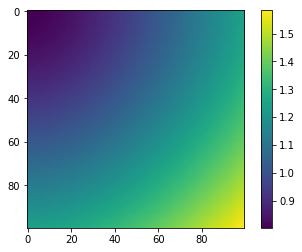

In [26]:
computeExpectedNormFunction()

mean relative error 1.071846%
max relative error 2.421812%


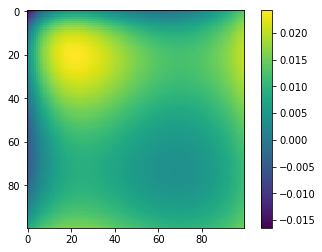

In [27]:
plotExpectedNormError()

In [28]:
unitTestExpectedAdd()

expected 0.11288815412406494 should be  0.11455493660533275+/-0.0010914821800410799 diff -0.001666782481267809


In [29]:
print(approxExpectedNorm (np.diag([1, 0.8, 0.01])))
print(approxExpectedNorm (np.diag([1, 0.01, 0.8])))
print(monteCarloExpectedNorm(np.diag([1, 0.8, 0.01])))
print(monteCarloExpectedNorm(np.diag([1, 0.01, 0.8])))

1.2038416952385143
1.2038416952385143
1.1932337779222575
1.194365833364024


## Global Optimization of the Rotation

By experiments we found out that mostly the above iterations converge very well, even from initial guesses 45deg wrong. Also, SO(3) is only three dimensional. Thus the idea for global optimization is to precompute a set of
equally spaced rotations, evaluate all of them and choose the one with the smallest value. From this rotation the translation is obtained via Schur-complement. The result is an initial guess for the 6D-optimization problem.

In [30]:
# ********************* Global Optimization of the Rotation *******************
def football ():
    '''Returns the vertex list of a trucated icosahedron (football), where all vectors have
       been scaled to unit length. (https://en.wikipedia.org/wiki/Truncated_icosahedron)'''
    def buildVertex (v, n, s):
        '''Cycles the v-coordinates by n in the order x-y-z-x and changes sign of all components according to
        s in [0..7]. Also normalizes to unit length.'''
        x = v[n]
        if s&1: x=-x
        y = v[(n+1)%3]
        if s&2: y=-y
        z = v[(n+2)%3]
        if s&4: z=-z
        n = 1/math.sqrt(x**2+y**2+z**2)
        return [x*n,y*n,z*n]

    phi = (1+math.sqrt(5))/2 # golden ratio
    A = [[0,1,3*phi], [1, 2+phi,2*phi], [phi, 2,phi**3]]
    return [buildVertex(v, n, s) for v in A for n in range (0,3) for s in range(0,8) if v[0]!=0 or (s&1)==0]

def footballA ():
    '''Returns football() as a matrix where every column is a 4-entry vector with 1 as last entry.'''
    f1 = football()
    f2 = [[p[0], p[1], p[2], 1] for p in f1]
    return np.array(f2).T
    
def setOfRotations (angularResolution=None):
    '''Returns a set of roughly equally space rotations. If angularResolution in None
    At the moment it is obtained by using an truncated
    icosahedron (football) pattern for the X-axis which has a spacing of roughly 23deg, followed by a rotation
    around the X-axis in sixteen 22.5deg steps. For a given angularResolution,
    it is computed by rotation Z-Y-X in the given resolution ignoring the fact that this is more dense
    at singularities.'''

    
    def makeRotation (xAxis, angle):
        '''Makes a 3*3 rotation matrix which has xAxis as first column. angle rotates the y and z axis around
        the x-Axis, where the direction corresponding to angle=0 is arbitrary.'''
        xAxis = xAxis/np.linalg.norm(xAxis)
        # Find a vector v non-collinear with xAxis
        if abs(xAxis[0])<abs(xAxis[1]):
            if abs(xAxis[0])<abs(xAxis[2]): 
                v = [1,0,0] 
            else:
                v = [0,0,1]
        else:
            if abs(xAxis[1])<abs(xAxis[2]):
                v = [0,1,0] 
            else:
                v = [0,0,1]
        yAxis = np.cross(xAxis, v)
        yAxis /= np.linalg.norm(yAxis)
        zAxis = np.cross(xAxis, yAxis)
        c = math.cos(angle)
        s = math.sin(angle)
        return np.vstack((xAxis, c*yAxis+s*zAxis, -s*yAxis+c*zAxis)).T

    
    myFootball = football()
    
    # Now combine every football vertex as x-axis with rotating y/z in steps of 360/16 degrees
#     rots = [makeRotation(v, i*math.pi/8) for v in myFootball for i in range(0,16)]

    R_1degY = [makeRotation(np.array([0,1,0]), np.pi/180. * i * 4) for i in range(6)]
    R_1degZ = [makeRotation(np.array([0,0,1]), np.pi/180. * i * 4) for i in range(6)]
    rots = [makeRotation(ry.dot(rz).dot(v), i*math.pi/45) for v in myFootball for i in range(0,90) for ry in R_1degY for rz in R_1degZ]
    for R in rots:
        np.testing.assert_almost_equal (R.T.dot(R), np.identity(3))
    return rots

rotationSet = setOfRotations()
rotationSetBar = [RToRBar(R) for R in rotationSet]
rotationSetBarA = np.array(rotationSetBar)

def evaluateR (Ptilde, rbar, h):
    '''Evaluates the const function defined by Ptilde on rbar and checks that h.dot(rbar)>=0'''
    if h.dot(rbar)>=0: 
        return rbar.T.dot(Ptilde).dot(rbar)
    else:
        return math.inf

def initialGuessR (Ptilde, h=np.zeros(10)):
    '''Provides an initial guess for the rotation by returning the rotation in rotationsSet (roughly 23deg space)
       with the smallest error. It only considers rotations rbar where h.dot(rbar)>=0. This can be used to filter
       out rotations where the resulting translation would be behind the camera.'''
    res = [evaluateR(Ptilde, rbar, h) for rbar in rotationSetBar]
    idx = np.argmin(res)
    return rotationSet[idx]

def initialGuessT (MtM):
    '''Provides an initial guess for a transform, by separating into rotation and translation via Schur-complement
       and calling initialGuessR for the rotation part.'''
    Ptilde, H, _ = schurComplement (MtM, 10)
    R = initialGuessR (Ptilde, H[2]) # H.dot(rbar)[2] is the Z-coordinate of the origin
    return RtToT (R, H.dot(RToRBar(R))) # full transform

def iterateOnMtM (MtM, l, options=xnpDefaultOptions()):
    '''Takes a XnP-Problem described by MtM, derives an initial guess (unless provided), makes some iterations
       and returns the result, its chi2-error and its information matrix, where the latter
       two have been scaled to get rid of the implicit average-z factor in MtM using l
       or by scaling the value to normalizeValTo.'''
    TBreve = options.get("initialGuess", None)
    if TBreve is None: TBreve = initialGuessT (MtM)
    return optimizeTLoop (MtM, l, TBreve, options)

In [31]:
# Running through example
print(initialGuessT (ex.MtM))
print(ex.OInR)

[[ 0.20177411  0.97943209  0.          1.93317311]
 [ 0.97943209 -0.20177411  0.         -2.03853123]
 [ 0.          0.         -1.          9.63839371]
 [ 0.          0.          0.          1.        ]]
[[ 0  1  0  2]
 [ 1  0  0 -2]
 [ 0  0 -1 10]
 [ 0  0  0  1]]


In [32]:
# Main function
def pnp (cam, data, options=xnpDefaultOptions()):
    '''Wrapping function for the whole algorithm. The input is the list of data-entries, where every entry is
       a flattened tuple, with point in object coordinates, 2*2 weighting matrix, and point in image coordinates.
       The function returns the estimated transform, chi2-error value normalized by the weight and a inverse
       covariance matrix (6*6 using [+]-operator on SE(3)).
       See top of notebook for a reference for the various options.'''
    TBreve = options.get("initialGuess", None)
    for ctr in range(options.get("fullIterations", 1)):
        if not options.get("useHuber", False): TBreve = None
        MtM, l = makeMtM (cam, data, TBreve)
        result = iterateOnMtM (MtM, l, options)
        TBreve = result[0]
    return result

def xnp (camsWithData, options=xnpDefaultOptions()):
    '''Wrapping function arbitray many cameras of arbitraty type. camsWithDatacamAndDatas is a list of pairs
       (cam, data) for all the cameras. All cameras can be both perspective and depth.
       The function returns the estimated transform, chi2-error value normalized by the weight and a inverse
       covariance matrix (6*6 using [+]-operator on SE(3)).
       See top of notebook for a reference for the various options.'''
    TBreve = options.get("initialGuess", None)
    for ctr in range(options.get("fullIterations", 1)):
        if not options.get("useHuber", False): TBreve = None
        MtM, l = makeMtMCamWithData (camsWithData, options.get("initialGuess", None)) 
        result = iterateOnMtM (MtM, l, options)
        TBreve = result[0]
    return result

In [33]:
# Running through example
ex.OInREst, ex.val, _ = pnp (ex.cam, ex.data)
ex.rms = rmsOfVal (ex.cam, ex.data, ex.val)
ex.rms2 = sqrt(errorOfDataForT (ex.cam, ex.data, ex.OInREst)/(2*len(ex.data)))
print (ex.OInREst)
print (ex.OInR)
print ("FrobErr %6f rms %4f rms according to raw computation %4f"%
       (frobErr(ex.OInREst, ex.OInR), ex.rms, ex.rms2))

error value of full system: 104286.803462
error value of full system: 4297.201125
error value of full system: 3178.959860
error value of full system: 3177.696288
error value of full system: 3177.696288
error value of full system: 3177.696288
error value of full system: 3177.696288
error value of full system: 3177.696288
[[-9.05490394e-03  9.99958685e-01 -7.98649074e-04  1.99402611e+00]
 [ 9.99938726e-01  9.04963113e-03 -6.37561109e-03 -1.98555713e+00]
 [-6.36812020e-03 -8.56330684e-04 -9.99979357e-01  9.94336571e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 0  1  0  2]
 [ 1  0  0 -2]
 [ 0  0 -1 10]
 [ 0  0  0  1]]
FrobErr 0.060813 rms 0.900283 rms according to raw computation 0.902675


In [34]:
#******************* Statistical evaluation of PnP performance **************
def runPnPOnce (options):
    cam  = randomCam ()
    OInR = randomOInR (cam, 10)
    data = makeData(20, cam, OInR, 0.2, 1, 5, "gauss")
    TNew, val, Omega = pnp (cam, data, options)
    val2 = errorOfDataForT (cam, data, TNew)
    return np.array([rmsOfVal(cam, data, val), rmsOfVal(cam, data, val2), expectedRms (cam, data), 
                     chi2Error(OInR, TNew, Omega), 6,
                     frobErr(OInR, TNew)])

def runPnP (nrOfRuns):
    '''Runs pnp on random data nrOfRuns times and returns statistics. See printStats'''
    myOptions = xnpDefaultOptions()
    myOptions["verbose"]=False
    myOptions["useHuber"]=False
    statList = np.array([runPnPOnce(myOptions) for i in range(nrOfRuns)])
    return sum(statList)/len(statList)

In [35]:
# Test several runs on the pnp algorithm 
stats = runPnP (1000)
print("Please note the the Huber-expected numbers are less theoretically solid and less precise.")
printStats (stats)

Please note the the Huber-expected numbers are less theoretically solid and less precise.
Avg. rms 0.9209, raw 0.9197 (expected 0.9220), Chi^2 of pose: 6.3603 (expected 6.0000), Frob-Err:0.1043


In [36]:
#********************* Statistical evaluation of PnP performance with Huber and two fullierations scheme without initial guesss **********************+
def runPnPHuberOnce (options):
    try:
        cam  = randomCam ()
        OInR = randomOInR (cam, 10)
        data = makeData(30, cam, OInR, 0.2, 1, 5, "gauss+outlier")
        TNew, val, Omega = pnp (cam, data, options)
        val2 = errorOfDataForT (cam, data, TNew, options.get("useHuber", False))
        expRms = sqrt(expectedHuberLoss)*expectedRms(cam, data)
        expChi2 = expectedHuberLoss*6
        chi2 = chi2Error(OInR, TNew, Omega)
    except:
        print("Failure")
        return [0,0,0,0,0,0]
    if chi2>=1000:
        print("\noutlier %f"%(chi2))
        print(OInR)
        print(TNew)
        print(frobErr(OInR, TNew))
        return [0,0,0,0,0,0]
    return np.array([rmsOfVal(cam, data, val), rmsOfVal(cam, data, val2), expRms, chi2, expChi2, frobErr(OInR, TNew)])

def runPnPHuber (nrOfRuns):
    '''Runs pnp on random data nrOfRuns times and returns statistics. See printStats'''
    myOptions = xnpDefaultOptions()
    myOptions["verbose"]=False
    myOptions["useHuber"]=True
    myOptions["fullIterations"]=2
    statList = np.array([runPnPHuberOnce(myOptions) for i in range(nrOfRuns)])
    return sum(statList)/len(statList)

In [37]:
# Test several runs on the pnp two fullIterations algorithm with Huber
stats = runPnPHuber (1000)
printStats (stats)


outlier 1889.862082
[[-0.12879247 -0.28292265  0.95045635  3.69809275]
 [ 0.84693252  0.46719703  0.25383507  0.53294086]
 [-0.51586608  0.83766444  0.17944494  5.57680534]
 [ 0.          0.          0.          1.        ]]
[[-0.06516157 -0.43128415  0.89985996  2.81622746]
 [ 0.76222069  0.56049515  0.32382836  0.28825766]
 [-0.64402919  0.70699305  0.29221095  4.29463911]
 [ 0.          0.          0.          1.        ]]
1.6053420785332417
Avg. rms 1.8901, raw 1.8122 (expected 1.8351), Chi^2 of pose: 37.4969 (expected 22.4738), Frob-Err:0.2715


In [38]:
#********************* Example for a heterogenous multi-camera setting: 2*perspective plus depth *****************
def runXnPOnce (options):
    cam1  = randomCam ("perspective")
    cam2  = randomCam ("perspective")
    cam3  = randomCam ("depth")
    OInR  = randomOInR (cam1, 10)
    data1 = makeData(30, cam1, OInR, 0.2, 1, 5, "gauss")
    data2 = makeData(30, cam2, OInR, 0.2, 1, 5, "gauss")
    data3 = makeDepthData(30, cam3, OInR, 0.2, 0.01, 0.05, "gauss")
    camWithData = [(cam1,data1)] #, (cam2,data2), (cam3,data3)]
    OInREst, val, Omega  = xnp (camWithData, options)
    val2 = errorOfCamWithDataForT (camWithData, OInREst, options.get("useHuber", False))
    expRms = expectedRmsForCamWithData (camWithData)
    expChi2 = 6
    chi2 = chi2Error(OInR, OInREst, Omega)
    return np.array([rmsOfValForCamWithData(camWithData, val), 
                     rmsOfValForCamWithData(camWithData, val2), 
                     expRms, chi2, expChi2, frobErr(OInR, OInREst)])

    
def runXnP (nrOfRuns):
    '''Runs pnp on random data nrOfRuns times and returns statistics. See printStats'''
    myOptions = xnpDefaultOptions()
    myOptions["verbose"]=False
    statList = np.array([runXnPOnce(myOptions) for i in range(nrOfRuns)])
    return sum(statList)/len(statList)

In [39]:
# Test several runs on the xnp algorithm with 2 perspective and 1 depth-camera
stats = runXnP (1000)
printStats (stats)

Avg. rms 0.9491, raw 0.9475 (expected 0.9000), Chi^2 of pose: 6.3726 (expected 6.0000), Frob-Err:0.0877
